# Script Noticias to Embedding

Embeddings a utilizar (todos con `lowercase`):

- Beto (Bert entrenado al español)
- Elmo
- FastText

In [44]:
# Importar librerías
import json
import pandas as pd
import numpy as np
from skmultilearn.model_selection import IterativeStratification
import nltk
from nltk.tokenize import RegexpTokenizer
from os.path import join, exists
from IPython.display import clear_output

# Descargar archivos necesarios por nltk
nltk.download('punkt')

clear_output()

# Leer, procesar daaset y generar vocabulario.

In [45]:
# Cargar dataset
df = pd.read_csv('NewsInformation.csv')

# Cargar texto asociado a cada fila.
def load_text(code):
    text_path = join('TXT', "{}.txt".format(code))
    if not exists(text_path):
        return "None"
    try:
        with open(text_path, encoding="UTF-8") as file:
            return file.read().replace("\r", "").replace("\n", " ")
    except:
        with open(text_path, encoding="latin-1") as file:
            return file.read().replace("\r", "").replace("\n", " ")

df["original_text"] = df.code.map(load_text)
# Filtrar None
df = df[df["original_text"] != "None"]

# Aplicar tokenizador al texto y minuscula
tkr = RegexpTokenizer('[a-zA-Z0-9áéíóú]+')
df['text'] = df['original_text'].apply(lambda text: " ".join([t for t in tkr.tokenize(text) ]).lower() )

# Dejar como lista los frames
df['frames'] = [np.array(x) for x in zip(df.conflict_fr.tolist(), df.econ_fr.tolist(), df.humint_fr.tolist(), df.morality_fr.tolist()) ]

df = df[['original_text', 'text', 'frames']]
df.head()

,original_text,text,frames
0,Japón registró un nuevo déficit comercial réco...,japón registró un nuevo déficit comercial réco...,"[0, 1, 0, 0]"
1,"UDI acusa ""mala memoria"" de la Nueva Mayoría f...",udi acusa mala memoria de la nueva mayoría fre...,"[1, 0, 0, 1]"
2,La misteriosa oferta por Esteban Paredes que i...,la misteriosa oferta por esteban paredes que i...,"[1, 0, 0, 0]"
3,La familia maratón que causó revuelo en Holand...,la familia maratón que causó revuelo en holand...,"[0, 0, 1, 0]"
4,Crean sitio web que recopila mangas descontin...,crean sitio web que recopila mangas descontinu...,"[0, 1, 0, 0]"


In [46]:
from collections import Counter

word_list = []
word_doc_counter = {}

for _, row in df.iterrows():
    text = row.text.split()

    new_text = []
    for word in text:
        if word.isnumeric():
            new_text.append("[NUM]")
        else:
            new_text.append(word)

    word_list.extend(new_text)
    
    for word in set(new_text): # Unique words
        if word not in word_doc_counter:
            word_doc_counter[word] = 0
        word_doc_counter[word] += 1

counter = Counter(word_list)

K = 5
# Solo quedarme con palabras que aparecen en 5 o más documentos.
vocabulary = [(word, count) for word, count in counter.items() if word_doc_counter[word] >= K]
len(vocabulary)

14513

In [47]:
# Ordenar por su frecuencia de menor a mayor
vocabulary.sort(key=lambda x:x[1])
vocabulary = vocabulary[-10000:] # OJO: Aquí te faltó invertir la lista de mayor a menor y ahí sacar los 10.000 

with open("vocabulary_corpus_counter.txt", "w", encoding="utf-8") as file:
    for word, count in vocabulary:
        file.write(f"{word}: {count}\n")

        
!head -10 vocabulary_corpus_counter.txt

plantaciones: 10
lamentando: 10
cerrados: 10
alessandro: 10
consejero: 10
tituló: 10
temen: 10
cha: 10
vih: 10
percató: 10


In [48]:
vocabulary_set = set([x[0] for x in vocabulary])

preprocess_text = []
for i, x in df.iterrows():
    text = x.text.split()
    new_text = []
    for word in text:
        if word in vocabulary_set:
            new_text.append(word)
        elif word.isnumeric():
            new_text.append("[NUM]")
        else:
            new_text.append("[UNK]")
            
    preprocess_text.append(" ".join(new_text))
    
df['preprocess_text'] = preprocess_text

#creating vocabulary
vocab = [x.strip().split(": ")[0] for x in open("vocabulary_corpus_counter.txt", encoding="UTF-8").readlines()]

vocab_to_idx = {"[PAD]":0, "[UNK]":1}
for word in vocab:
    vocab_to_idx[word] = len(vocab_to_idx)
    
def encode_sentence(text, vocab_to_idx):
    enc1 = [vocab_to_idx.get(word, 1) for word in text.split()]
    return np.array(enc1)

df['encoded'] = df['preprocess_text'].apply(lambda x: np.array(encode_sentence(x, vocab_to_idx)))

df["conflicto"] = [x[0] for x in df.frames]
df["economico"] = [x[1] for x in df.frames]
df["humanidad"] = [x[2] for x in df.frames]
df["moral"] = [x[3] for x in df.frames]

del df["text"]
df = df[['original_text', 'preprocess_text', 'encoded', 'frames', 'conflicto', 'economico', 'humanidad', 'moral']]
df.head()

,original_text,preprocess_text,encoded,frames,conflicto,economico,humanidad,moral
0,Japón registró un nuevo déficit comercial réco...,japón registró un nuevo déficit comercial réco...,"[8759, 8914, 9989, 9898, 6584, 8773, 8428, 999...","[0, 1, 0, 0]",0,1,0,0
1,"UDI acusa ""mala memoria"" de la Nueva Mayoría f...",udi acusa mala memoria de la nueva mayoría fre...,"[9610, 8486, 8448, 7205, 10001, 9999, 9927, 97...","[1, 0, 0, 1]",1,0,0,1
2,La misteriosa oferta por Esteban Paredes que i...,la misteriosa oferta por esteban paredes que [...,"[9999, 1121, 8346, 9990, 8487, 8596, 9996, 1, ...","[1, 0, 0, 0]",1,0,0,0
3,La familia maratón que causó revuelo en Holand...,la familia maratón que causó revuelo en holand...,"[9999, 9668, 5417, 9996, 7388, 2016, 9997, 887...","[0, 0, 1, 0]",0,0,1,0
4,Crean sitio web que recopila mangas descontin...,crean sitio web que [UNK] [UNK] [UNK] para [UN...,"[2420, 9319, 9360, 9996, 1, 1, 1, 9985, 1, 998...","[0, 1, 0, 0]",0,1,0,0


In [49]:
np.save("datasets/preprocess_dataset.npy", df.values)

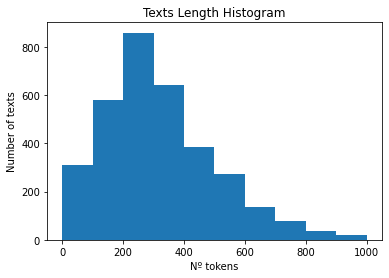

In [29]:
import matplotlib.pyplot as plt

histogram = []
for i, x in df.iterrows():
    text = x.preprocess_text.split()
    count = sum([1 for x in text if x != "[UNK]"])
    histogram.append(count)
        
# the histogram of the data
_, bins, _ = plt.hist(histogram, range=[0, 1000])
plt.title('Texts Length Histogram')
plt.xlabel('Nº tokens')
plt.ylabel('Number of texts')
plt.show()


In [20]:
columns = ['original_text', 'preprocess_text', 'encoded', 'frames',
           'conflicto', 'economico', 'humanidad', 'moral']

df = np.load("datasets/preprocess_dataset.npy", allow_pickle=True)
df = pd.DataFrame(df, columns=columns)

labels_df = df[['conflicto', 'economico', 'humanidad', 'moral']]
print(labels_df.sum(axis=0))
print("\nPercentage\n")
print(labels_df.sum(axis=0)/labels_df.sum().sum())

conflicto    1117
economico     550
humanidad    1497
moral         754
dtype: object

Percentage

conflicto    0.285094
economico    0.140378
humanidad    0.382083
moral        0.192445
dtype: object


In [33]:
count_frames = df.frames.map(lambda x: sum(x))

print(count_frames.value_counts().sort_index())

print("\nPercentage\n")
print(count_frames.value_counts().sort_index()/count_frames.value_counts().sum())

0     973
1    1352
2     732
3     314
4      40
Name: frames, dtype: int64

Percentage

0    0.285254
1    0.396365
2    0.214600
3    0.092055
4    0.011727
Name: frames, dtype: float64


## Preprocessing aditional dataset

In [57]:
#creating vocabulary
vocab = [x.strip().split(": ")[0] for x in open("vocabulary_corpus_counter.txt", encoding="UTF-8").readlines()]

vocab_to_idx = {"[PAD]":0, "[UNK]":1}
for word in vocab:
    vocab_to_idx[word] = len(vocab_to_idx)
    
def encode_sentence(text, vocab_to_idx):
    enc1 = [vocab_to_idx.get(word, 1) for word in text.split()]
    return np.array(enc1)

df_2 = pd.read_csv("news_dataset_2.tsv", sep="\t")
df_2["original_text"] = df_2["text"]

# Aplicar tokenizador al texto y minuscula
tkr = RegexpTokenizer('[a-zA-Z0-9áéíóú]+')
df_2['text'] = df_2['text'].apply(lambda text: " ".join([t for t in tkr.tokenize(text) ]).lower() )
df_2['frames'] = [np.array(x) for x in zip(df_2.conflict.tolist(), df_2.economy.tolist(), df_2.humanity.tolist(), df_2.moral.tolist()) ]

df_2 = df_2[["original_text", "text", "frames"]]

preprocess_text_2 = []
for i, x in df_2.iterrows():
    text = x.text.split()
    new_text = []
    for word in text:
        if word in vocabulary_set:
            new_text.append(word)
        elif word.isnumeric():
            new_text.append("[NUM]")
        else:
            new_text.append("[UNK]")
            
    preprocess_text_2.append(" ".join(new_text))
    
df_2['preprocess_text'] = preprocess_text_2
df_2['encoded'] = df_2['preprocess_text'].apply(lambda x: np.array(encode_sentence(x, vocab_to_idx)))

df_2["conflicto"] = [x[0] for x in df_2.frames]
df_2["economico"] = [x[1] for x in df_2.frames]
df_2["humanidad"] = [x[2] for x in df_2.frames]
df_2["moral"] = [x[3] for x in df_2.frames]

del df_2["text"]
df_2 = df_2[['original_text', 'preprocess_text', 'encoded', 'frames', 'conflicto', 'economico', 'humanidad', 'moral']]

np.save("datasets/preprocess_dataset_2.npy", df_2.values)

df_2.head()

,original_text,preprocess_text,encoded,frames,conflicto,economico,humanidad,moral
0,"EM, lunes, 1.10.2007 ACUSA FALTA A ""PRINCIPIO ...",[UNK] lunes [NUM] [NUM] [NUM] acusa falta a pr...,"[1, 9840, 10000, 10000, 10000, 8486, 9571, 999...","[1, 0, 0, 1]",1,0,0,1
1,Edil reconoce error por omitir empresas en dec...,edil reconoce error por [UNK] empresas en decl...,"[4607, 7840, 9050, 9990, 1, 9455, 9997, 8748, ...","[1, 0, 0, 1]",1,0,0,1
2,"EM, viernes, 2.11.2007 A LA COMISIÓN INVESTIGA...",[UNK] viernes [NUM] [NUM] [NUM] a la [UNK] n i...,"[1, 9794, 10000, 10000, 10000, 9995, 9999, 1, ...","[1, 0, 1, 1]",1,0,1,1
3,La Moneda analiza texto de Lagos por Transanti...,la moneda analiza texto de lagos por transanti...,"[9999, 9383, 5236, 8685, 10001, 8798, 9990, 85...","[1, 1, 1, 1]",1,1,1,1
4,"PM, lunes, 26.3.2007 Moreira: “que Lagos asuma...",pm lunes [NUM] [NUM] [NUM] moreira que lagos [...,"[6583, 9840, 10000, 10000, 10000, 6095, 9996, ...","[1, 0, 0, 0]",1,0,0,0


# Cargar datasets y calcular embeddins
- FastText
- Elmo
- Beto

In [58]:
columns = ['original_text', 'preprocess_text', 'encoded', 'frames', 'conflicto', 'economico', 'humanidad', 'moral']

df = np.load("datasets/preprocess_dataset.npy", allow_pickle=True)
df = pd.DataFrame(df, columns=columns)

df.head()

,original_text,preprocess_text,encoded,frames,conflicto,economico,humanidad,moral
0,Japón registró un nuevo déficit comercial réco...,japón registró un nuevo déficit comercial réco...,"[8759, 8914, 9989, 9898, 6584, 8773, 8428, 999...","[0, 1, 0, 0]",0,1,0,0
1,"UDI acusa ""mala memoria"" de la Nueva Mayoría f...",udi acusa mala memoria de la nueva mayoría fre...,"[9610, 8486, 8448, 7205, 10001, 9999, 9927, 97...","[1, 0, 0, 1]",1,0,0,1
2,La misteriosa oferta por Esteban Paredes que i...,la misteriosa oferta por esteban paredes que [...,"[9999, 1121, 8346, 9990, 8487, 8596, 9996, 1, ...","[1, 0, 0, 0]",1,0,0,0
3,La familia maratón que causó revuelo en Holand...,la familia maratón que causó revuelo en holand...,"[9999, 9668, 5417, 9996, 7388, 2016, 9997, 887...","[0, 0, 1, 0]",0,0,1,0
4,Crean sitio web que recopila mangas descontin...,crean sitio web que [UNK] [UNK] [UNK] para [UN...,"[2420, 9319, 9360, 9996, 1, 1, 1, 9985, 1, 998...","[0, 1, 0, 0]",0,1,0,0


In [59]:
df_2 = np.load("datasets/preprocess_dataset_2.npy", allow_pickle=True)
df_2 = pd.DataFrame(df_2, columns=columns)

df_2.head()

,original_text,preprocess_text,encoded,frames,conflicto,economico,humanidad,moral
0,"EM, lunes, 1.10.2007 ACUSA FALTA A ""PRINCIPIO ...",[UNK] lunes [NUM] [NUM] [NUM] acusa falta a pr...,"[1, 9840, 10000, 10000, 10000, 8486, 9571, 999...","[1, 0, 0, 1]",1,0,0,1
1,Edil reconoce error por omitir empresas en dec...,edil reconoce error por [UNK] empresas en decl...,"[4607, 7840, 9050, 9990, 1, 9455, 9997, 8748, ...","[1, 0, 0, 1]",1,0,0,1
2,"EM, viernes, 2.11.2007 A LA COMISIÓN INVESTIGA...",[UNK] viernes [NUM] [NUM] [NUM] a la [UNK] n i...,"[1, 9794, 10000, 10000, 10000, 9995, 9999, 1, ...","[1, 0, 1, 1]",1,0,1,1
3,La Moneda analiza texto de Lagos por Transanti...,la moneda analiza texto de lagos por transanti...,"[9999, 9383, 5236, 8685, 10001, 8798, 9990, 85...","[1, 1, 1, 1]",1,1,1,1
4,"PM, lunes, 26.3.2007 Moreira: “que Lagos asuma...",pm lunes [NUM] [NUM] [NUM] moreira que lagos [...,"[6583, 9840, 10000, 10000, 10000, 6095, 9996, ...","[1, 0, 0, 0]",1,0,0,0


# Embeddings  

## Beto

In [61]:
import torch
from transformers import BertConfig, BertTokenizer, BertForPreTraining
from torch.utils.data import DataLoader, TensorDataset   

        
class InputFeatures(object):
    """A single set of features of data."""
    def __init__(self, input_ids, input_mask, segment_ids):
        self.input_ids = input_ids
        self.input_mask = input_mask
        self.segment_ids = segment_ids


def convert_example_to_feature(example_row):
    text, max_seq_length, tokenizer, cls_token, sep_token = example_row
    tokens_a = tokenizer.tokenize(text)
    
    # Account for [CLS] and [SEP] with "- 2"
    special_tokens_count = 2
    tokens_a = tokens_a[:(max_seq_length - special_tokens_count)]
    tokens = tokens_a + [sep_token]
    segment_ids = [0] * len(tokens)

    tokens = [cls_token] + tokens
    segment_ids = [0] + segment_ids

    input_ids = tokenizer.convert_tokens_to_ids(tokens)

    # The mask has 1 for real tokens and 0 for padding tokens. Only real
    # tokens are attended to.
    input_mask = [1] * len(input_ids)

    # Zero-pad up to the sequence length.
    padding_length = max_seq_length - len(input_ids)
    
    input_ids = input_ids + ([0] * padding_length)
    input_mask = input_mask + ([0] * padding_length)
    segment_ids = segment_ids + ([0] * padding_length)

    assert len(input_ids) == max_seq_length
    assert len(input_mask) == max_seq_length
    assert len(segment_ids) == max_seq_length

    return InputFeatures(
        input_ids=input_ids,
        input_mask=input_mask,
        segment_ids=segment_ids,
    )


def convert_examples_to_features(texts, max_seq_length, tokenizer, cls_token, sep_token):
    examples = [(text, max_seq_length, tokenizer, cls_token, sep_token) for text in texts]
    return [convert_example_to_feature(example) for example in examples]



class BetoEmbedding:
    def __init__(self, take_mean=True):
        self.tokenizer = BertTokenizer.from_pretrained('vocab.txt', keep_accents=True)
        config = BertConfig.from_json_file('bert_config.json')
        config.output_hidden_states = True
        self.bert = BertForPreTraining.from_pretrained('pytorch_model.bin', config=config)
        for p in self.bert.parameters():
            p.requires_grad = False
            
        self.take_mean = take_mean

    def __call__(self, X):
        
        tokenizer = self.tokenizer
        features = convert_examples_to_features(X, 512, tokenizer, tokenizer.cls_token,tokenizer.sep_token)

        all_input_ids = torch.tensor([f.input_ids for f in features], dtype=torch.long)
        all_input_mask = torch.tensor([f.input_mask for f in features], dtype=torch.long)
        all_segment_ids = torch.tensor([f.segment_ids for f in features], dtype=torch.long)

        train_dataset = TensorDataset(all_input_ids, all_input_mask, all_segment_ids)
        train_dataloader = DataLoader(train_dataset, batch_size=8, shuffle=False)
        device = torch.device("cuda")
        
        self.bert.to(device)

        CLS_VECTORS = None

        for batch in train_dataloader:
            input_ids, attention_mask, token_type_ids = tuple(t.to(device) for t in batch)

            outputs = self.bert(input_ids, attention_mask, token_type_ids)
                        
            # outputs[-1] = salidas de las capas ocultas (hidden_iniciales, capa_1, ..., capa_12)
            outputs = outputs[-1][-1] # Tomar de las hidden_state, la última capa

            if self.take_mean:
                output = torch.mean(outputs, 1)
            else:
                output = outputs[:, 0, :] # Tomar el primer vector (CLS)
                
            if CLS_VECTORS is None:
                CLS_VECTORS = output.detach().cpu().numpy()
            else:
                CLS_VECTORS = np.append(CLS_VECTORS, output.detach().cpu().numpy(), axis=0)

        return CLS_VECTORS

In [62]:
def get_beto_embedding(x):
    torch.manual_seed(4444)
    np.random.seed(4444)
    
    x = np.array([" ".join(text.split(" ")[:510]) for text in x])
    return BetoEmbedding(take_mean=True)(x)

beto_embedding_dataset_1 = get_beto_embedding(df.preprocess_text)
beto_embedding_dataset_2 = get_beto_embedding(df_2.preprocess_text)

Calling BertTokenizer.from_pretrained() with the path to a single file or url is deprecated
Some weights of BertForPreTraining were not initialized from the model checkpoint at pytorch_model.bin and are newly initialized: ['cls.predictions.decoder.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [63]:
np.save("datasets/beto_embedding_mean_dataset_1.npy", beto_embedding_dataset_1)
np.save("datasets/beto_embedding_mean_dataset_2.npy", beto_embedding_dataset_2)

In [64]:
def get_beto_embedding(x):
    torch.manual_seed(4444)
    np.random.seed(4444)
    
    x = np.array([" ".join(text.split(" ")[:510]) for text in x])
    return BetoEmbedding(take_mean=False)(x)


beto_embedding_dataset_1 = get_beto_embedding(df.preprocess_text)
beto_embedding_dataset_2 = get_beto_embedding(df_2.preprocess_text)

Calling BertTokenizer.from_pretrained() with the path to a single file or url is deprecated
Some weights of BertForPreTraining were not initialized from the model checkpoint at pytorch_model.bin and are newly initialized: ['cls.predictions.decoder.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [65]:
np.save("datasets/beto_embedding_cls_dataset_1.npy", beto_embedding_dataset_1)
np.save("datasets/beto_embedding_cls_dataset_2.npy", beto_embedding_dataset_2)

## Elmo

In [66]:
import json
import numpy as np
from ELMoForManyLangs.elmoformanylangs import Embedder

elmo = Embedder('ElMoSpanishEmbedding/')
clear_output()

In [67]:
original = torch.cuda.is_available

torch.cuda.is_available = lambda :False

In [68]:
torch.cuda.is_available()

False

In [72]:
import logging

# Desabilitamos el logging para que la librería de ELMo no haga prints
logger = logging.getLogger()
logger.disabled = True

def save_elmo(df, filename):
    max_length_text = 512

    total = len(df)
    elmo_embedding = []
    for i, text in enumerate(df.preprocess_text):
        print(f"\r{i}/{total}", end="")

        embedding = elmo.sents2elmo([text.split()[:max_length_text]], output_layer=-1)[0]
        elmo_embedding.append(np.mean(embedding, axis=0))

    data_elmo =  np.array(elmo_embedding)

    # Salvar Elmo Embeddings comprimodo
    np.savez_compressed(f'datasets/{filename}.npz', data_elmo)
    print("")
    
save_elmo(df, "elmo_dataset_1")
save_elmo(df_2, "elmo_dataset_2")

logger.disabled = False

3410/3411


## FastText

In [70]:
from gensim.models.keyedvectors import KeyedVectors

wordvectors_file_vec = 'embeddings-l-model.vec'
wordvectors = KeyedVectors.load_word2vec_format(wordvectors_file_vec)

2021-06-09 12:00:56,760 INFO: loading projection weights from embeddings-l-model.vec
2021-06-09 12:04:42,330 INFO: loaded (1313423, 300) matrix from embeddings-l-model.vec


In [71]:
# Generamos diccionario de fastText
fastText = {}

import nltk
from nltk.corpus import stopwords  

nltk.download('stopwords')
spanish_stopwords = set(stopwords.words('spanish') + ["[UNK]", "[NUM]"] )


def apply_FastText(text):
    data = []
    for i, word in enumerate(text):
        
        if word in spanish_stopwords:
            continue
            
        if word in wordvectors:
            data.append(wordvectors[word])
            
    return np.mean(np.array(data), axis=0)


def save_fastText(texts, filename):
    total = len(texts)
    fastText_data = []
    
    for i, text in enumerate(texts):
        print(f"\r{i}/{total}", end="")
        embedding = apply_FastText(text.split())
        fastText_data.append(embedding)

    fastText_data =  np.array(fastText_data)

    # Salvar Falstext Embeddings comprimodo
    np.savez_compressed(f'datasets/{filename}.npz', fastText_data)
    print()

save_fastText(df.preprocess_text, "fasttext_dataset_1")
save_fastText(df_2.preprocess_text, "fasttext_dataset_2")

[nltk_data] Downloading package stopwords to
[nltk_data]     /home/hfvaldivieso/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


701/702
